# Quick Start with AAanalysis
**AAanalysis** is a Python framework for sequence-based protein prediction, centered around the **Comparative Physical Profiling (CPP)** algorithm for interpretable feature engineering.

First, import some third-party packages and ``aanalsis``:

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import aaanalysis as aa
aa.options["verbose"] = False

We can load a dataset of amino acid scales and an example dataset for γ-secretase of 50 substrates and 50 non-substrates:

In [2]:
# Load example dataset and scales
df_seq = aa.load_dataset(name="DOM_GSEC", n=50)
labels = list(df_seq["label"])
df_scales = aa.load_scales()

**Feature Engineering**

To start feature engineering, we can utilize the  ``AAclust`` model for pre-selecting a redundancy-reduced set of amino acid scales:

In [3]:
# Obtain redundancy-reduced set of 100 scales
aac = aa.AAclust()
X = np.array(df_scales).T
scales = aac.fit(X, names=list(df_scales), n_clusters=100).medoid_names_ 
df_scales = df_scales[scales]

We can now use the ``CPP`` algorithm, which aims at identifying a set of features most discriminant between two sets of sequences. Its core idea is the CPP feature concept, defined as a combination of **Parts**, **Splits**, and **Scales**. Parts and Splits can be obtained using ``SequenceFeature``.

We first create a set of baseline features:

In [4]:
sf = aa.SequenceFeature()

# Obtain Parts and Splits
df_parts = sf.get_df_parts(df_seq=df_seq, list_parts=["tmd"])
split_kws = sf.get_split_kws(n_split_max=1, split_types=["Segment"])

Running CPP creates all **Part-Split-Scale** combinations and filters a selected maximum of non-redundant features. As a baseline approach,
we use CPP without filtering (`max_cor=1`) to compute the average values for the 100 selected scales over the entire TMD sequences:

In [5]:
# CPP creates 100 baseline features (Scale values averaged over TMD)
cpp = aa.CPP(df_scales=df_scales, df_parts=df_parts, split_kws=split_kws)
df_feat_baseline = cpp.run(labels=labels, max_cor=1)
aa.display_df(df=df_feat_baseline, n_rows=10)

,feature,category,subcategory,scale_name,scale_description,abs_auc,abs_mean_dif,mean_dif,std_test,std_ref,p_val_mann_whitney,p_val_fdr_bh,positions
1,"TMD-Segment(1,1)-ANDN920101",Structure-Activity,Backbone-dynamics (-CH),α-CH chemical s...kbone-dynamics),"alpha-CH chemic...n et al., 1992)",0.230000,0.065000,-0.065000,0.072000,0.078000,0.000076,0.003320,"11,12,13,14,15,...,26,27,28,29,30"
2,"TMD-Segment(1,1)-WARP780101",ASA/Volume,Buried,Interactivity,"Average interac...e-Morgan, 1978)",0.229000,0.029000,0.029000,0.032000,0.038000,0.000080,0.003320,"11,12,13,14,15,...,26,27,28,29,30"
3,"TMD-Segment(1,1)-EISD840101",Polarity,Hydrophobicity,Hydrophobicity,"Consensus norma...isenberg, 1984)",0.226000,0.023000,0.023000,0.025000,0.033000,0.000100,0.003320,"11,12,13,14,15,...,26,27,28,29,30"
4,"TMD-Segment(1,1)-CHOC760103",ASA/Volume,Buried,Buried,"Proportion of r...(Chothia, 1976)",0.218000,0.040000,0.040000,0.045000,0.056000,0.000174,0.003949,"11,12,13,14,15,...,26,27,28,29,30"
5,"TMD-Segment(1,1)-FASG760105",Polarity,Unclassified (Polarity),pK-C,"pK-C (Fasman, 1976)",0.215000,0.041000,0.041000,0.039000,0.057000,0.000220,0.003949,"11,12,13,14,15,...,26,27,28,29,30"
6,"TMD-Segment(1,1)-FINA910101",Conformation,α-helix (N-cap),α-helix initiation,"Helix initiatio...n et al., 1991)",0.211000,0.018000,-0.018000,0.023000,0.024000,0.000271,0.003949,"11,12,13,14,15,...,26,27,28,29,30"
7,"TMD-Segment(1,1)-YUTK870104",Energy,Free energy (unfolding),Free energy (unfolding),"Activation Gibb...i et al., 1987)",0.209000,0.008000,0.008000,0.011000,0.017000,0.000311,0.003949,"11,12,13,14,15,...,26,27,28,29,30"
8,"TMD-Segment(1,1)-ENGD860101",Polarity,Hydrophilicity,Polarity (hydrophilicity),"Hydrophobicity ...n et al., 1986)",0.207000,0.017000,-0.017000,0.017000,0.025000,0.000370,0.003949,"11,12,13,14,15,...,26,27,28,29,30"
9,"TMD-Segment(1,1)-FUKS010106",Composition,Membrane proteins (MPs),Proteins of mesophiles (INT),"Interior compos...ishikawa, 2001)",0.206000,0.059000,0.059000,0.068000,0.082000,0.000380,0.003949,"11,12,13,14,15,...,26,27,28,29,30"
10,"TMD-Segment(1,1)-KOEH090102",Polarity,Hydrophilicity,Polarity (hydrophilicity),Hydrophobicity ...r et al. (2009),0.206000,0.026000,-0.026000,0.029000,0.039000,0.000395,0.003949,"11,12,13,14,15,...,26,27,28,29,30"


By default, ``CPP`` creates around 1000 **Part-Slit** combinations:

In [6]:
# CPP creates with default parts and splits around 100.000 features and filters them down to 100
df_parts = sf.get_df_parts(df_seq=df_seq)
cpp = aa.CPP(df_scales=df_scales, df_parts=df_parts)
df_feat = cpp.run(labels=labels)
aa.display_df(df=df_feat, n_rows=10)

,feature,category,subcategory,scale_name,scale_description,abs_auc,abs_mean_dif,mean_dif,std_test,std_ref,p_val_mann_whitney,p_val_fdr_bh,positions
1,"TMD_C_JMD_C-Seg...2,3)-QIAN880106",Conformation,α-helix,α-helix (middle),"Weights for alp...ejnowski, 1988)",0.387000,0.121000,0.121000,0.069000,0.085000,0.000000,0.000000,"27,28,29,30,31,32,33"
2,"TMD_C_JMD_C-Seg...4,5)-ZIMJ680104",Energy,Isoelectric point,Isoelectric point,"Isoelectric poi...n et al., 1968)",0.373000,0.220000,0.220000,0.124000,0.137000,0.000000,0.000000,"33,34,35,36"
3,"TMD_C_JMD_C-Pat...,15)-QIAN880106",Conformation,α-helix,α-helix (middle),"Weights for alp...ejnowski, 1988)",0.358000,0.145000,0.145000,0.079000,0.118000,0.000000,0.000001,"25,28,32,35"
4,"TMD_C_JMD_C-Pat...,15)-MUNV940101",Energy,Free energy (folding),Free energy (α-helix),"Free energy in ...-Serrano, 1994)",0.358000,0.097000,-0.097000,0.050000,0.082000,0.000000,0.000001,"24,28,32,35"
5,"TMD_C_JMD_C-Seg...5,7)-LINS030101",ASA/Volume,Volume,Accessible surface area (ASA),"Total accessibl...s et al., 2003)",0.354000,0.237000,0.237000,0.146000,0.164000,0.000000,0.000001,"32,33,34"
6,"TMD_C_JMD_C-Seg...5,7)-KARS160114",Shape,Side chain length,Eccentricity (average),"Average weighte...-Knisley, 2016)",0.344000,0.229000,0.229000,0.156000,0.160000,0.000000,0.000001,"32,33,34"
7,"TMD_C_JMD_C-Seg...6,9)-ZIMJ680104",Energy,Isoelectric point,Isoelectric point,"Isoelectric poi...n et al., 1968)",0.341000,0.264000,0.264000,0.187000,0.172000,0.000000,0.000001,"32,33"
8,"TMD_C_JMD_C-Pat...,15)-GUYH850104",ASA/Volume,Accessible surface area (ASA),Partition energy,"Apparent partit...dex (Guy, 1985)",0.339000,0.137000,0.137000,0.079000,0.115000,0.000000,0.000001,"26,29,33,37"
9,"TMD_C_JMD_C-Seg...4,9)-ROBB760113",Conformation,β-turn,β-turn,"Information mea...n-Suzuki, 1976)",0.337000,0.319000,-0.319000,0.175000,0.256000,0.000000,0.000001,"27,28"
10,"TMD_C_JMD_C-Pat...4,8)-CHOC760103",ASA/Volume,Buried,Buried,"Proportion of r...(Chothia, 1976)",0.337000,0.267000,-0.267000,0.134000,0.229000,0.000000,0.000001,"33,37"


**Machine Learning**

A feature matrix from a given set of CPP features can be created using ``SequenceFeature.feature_matrix``:

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Create feature matrix and perform prediction for baseline features
X = sf.feature_matrix(df_parts=df_parts, features=df_feat_baseline["feature"])
rf = RandomForestClassifier()
cv_base = cross_val_score(rf, X, labels, scoring="accuracy", cv=5)
print(f"Mean accuracy of {round(np.mean(cv_base), 2)}")

Mean accuracy of 0.57


Creating more features with CPP will take a little time but improve prediction performance: 

In [8]:
# Create feature matrix and perform prediction for default CPP features
X = sf.feature_matrix(df_parts=df_parts, features=df_feat["feature"])
rf = RandomForestClassifier()
cv = cross_val_score(rf, X, labels, scoring="accuracy", cv=5) 
print(f"Mean accuracy of {round(np.mean(cv), 2)}")


Mean accuracy of 0.94


We can compare the baseline and default CPP feature set using a bar chart:

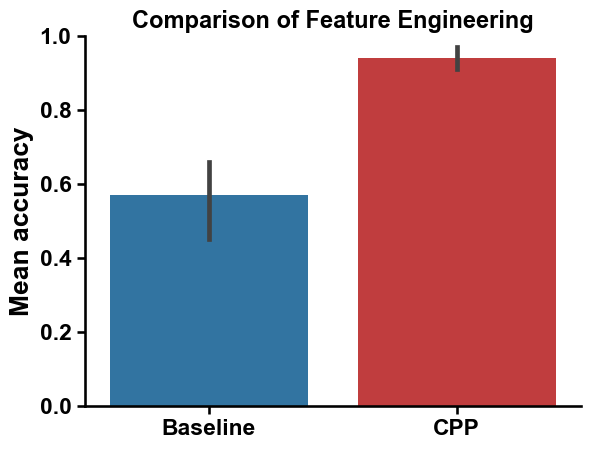

In [9]:
# Comparison of baseline and default CPP feature sets
aa.plot_settings()
sns.barplot(pd.DataFrame({"Baseline": cv_base, "CPP": cv}), palette=["tab:blue", "tab:red"])
plt.ylabel("Mean accuracy", size=aa.plot_gcfs()+1)
plt.ylim(0, 1)
plt.title("Comparison of Feature Engineering", size=aa.plot_gcfs()-1)
sns.despine()
plt.show()

**CPP Analysis (group level)**

AAanalysis offers various plotting functions for interpreting the CPP features at group and sample level by ``CPPPlot``. We first need to include the group-level feature importance using the ``TreeModel`` and its ``TreeModel.add_feat_importance`` method:

In [10]:
tm = aa.TreeModel()
tm.fit(X, labels=labels, use_rfe=False)
df_feat = tm.add_feat_importance(df_feat=df_feat, drop=True)

The top15 features can be displayed using the ``CPPPlot.ranking`` method. The features are shown (left) as a combination of the scale subcategory and their position derived from the part-split combination. The difference of feature values between the test and reference set of protein (here γ-secretase substrates and non-substrates) is shown in the middle. The right subplots displays the feature importance used for ranking:


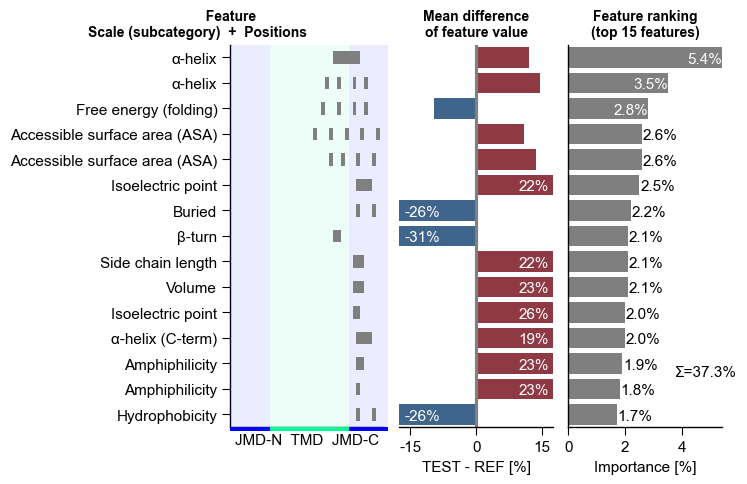

In [11]:
# Plot CPP ranking
cpp_plot = aa.CPPPlot()
aa.plot_settings(font_scale=0.65, weight_bold=False)
cpp_plot.ranking(df_feat=df_feat)
plt.show()

The cumulative feature importance per residue position can be visualized by the ``CPPPlot.profile`` method:

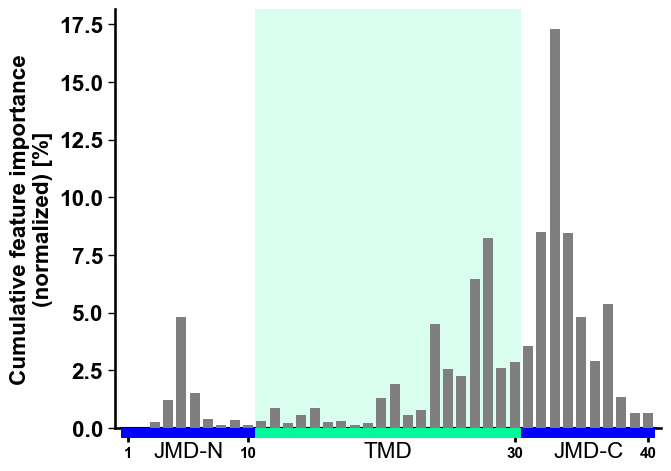

In [12]:
# Plot CPP profile
aa.plot_settings(font_scale=0.9)
cpp_plot.profile(df_feat=df_feat)
plt.show()

 To uncover the common physicochemical signature discriminating the test from the reference protein set, use the ``CPPPlot.feature_map`` method showing the feature value differences per scale subcategory at single-residue resolution:

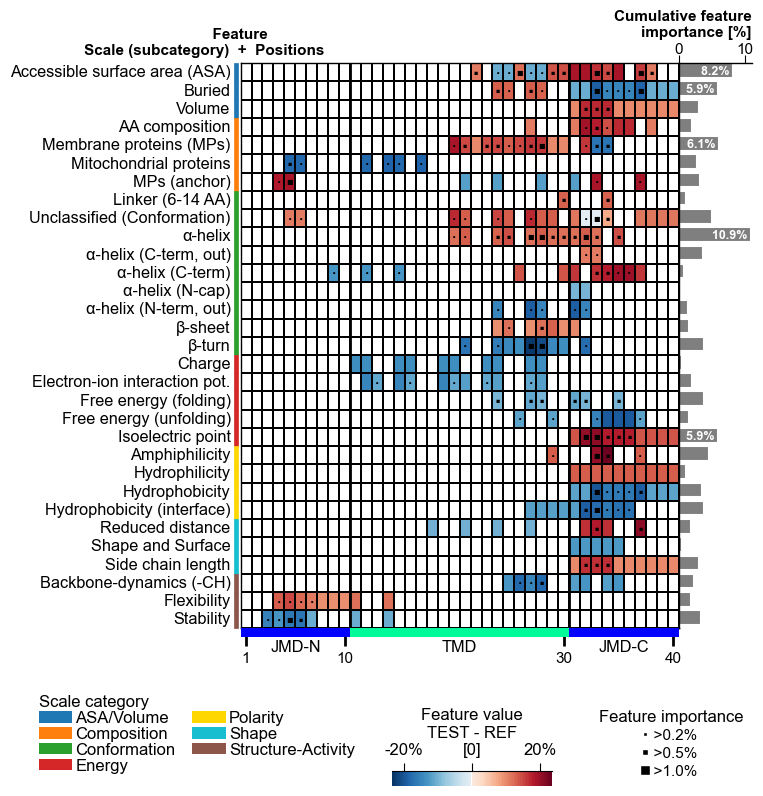

In [13]:
# Plot CPP feature map
cpp_plot = aa.CPPPlot()
aa.plot_settings(font_scale=0.65, weight_bold=False)
cpp_plot.feature_map(df_feat=df_feat)
plt.show()

**CPP-SHAP Analysis (sample level)**

We can analyse the impact of features on the prediction score for individual sequence using the ``ShapExplainer`` model, which combines ``CPP`` with the explainable AI framework `SHAP <https://shap.readthedocs.io/en/latest/index.html>`_.

In [14]:
se = aa.ShapExplainer()
se.fit(X, labels=labels)
df_feat = se.add_feat_impact(df_feat=df_feat, drop=True)
df_feat = se.add_sample_mean_dif(X, labels=labels, df_feat=df_feat, drop=True)

We can now show the feature ranking for a selected protein ('Protein0') using the ``CPPPlot.ranking`` method, plotting SHAP analysis results by setting ``shap_plot=True``

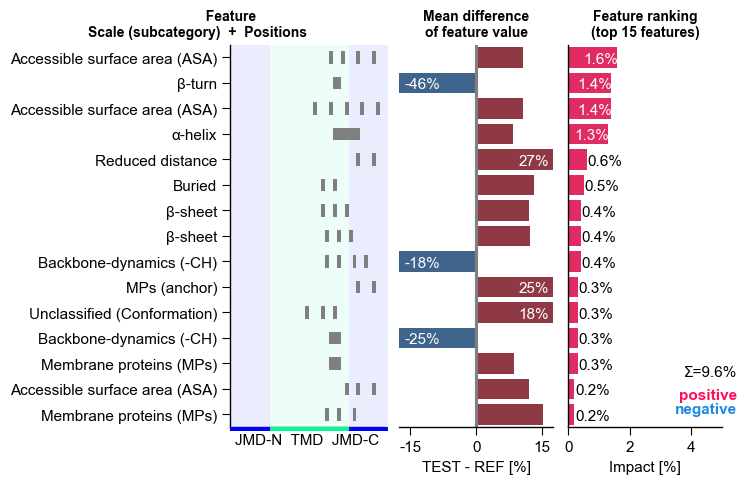

In [15]:
aa.plot_settings(font_scale=0.65, weight_bold=False)
cpp_plot.ranking(df_feat=df_feat, shap_plot=True, col_dif="mean_dif_Protein0", col_imp="feat_impact_Protein0")
plt.show()